### Importación de bibliotecas

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.ticker as ticker

### Estilos

In [3]:
estilo_corporativo = {
    'axes.facecolor': '#253837',  # color de fondo de los ejes
    'figure.facecolor': '#253837',  # color de fondo de la figura
    'axes.edgecolor': 'white',  # color del borde de los ejes
    'axes.labelcolor': 'white',  # color de las etiquetas
    'xtick.color': 'white',  # color del tick del eje x
    'ytick.color': 'white',  # color del tick del eje y
    'grid.color': 'gray',  # color de la cuadrícula
    'grid.linestyle': '--',  # línea de la cuadrícula
    'grid.linewidth': 0.5,  # grosor cuadrícula
    'axes.titlecolor': 'white'  # color del título
}


# EJEMPLO DE APLICACIÓN: (conservar primera línea y luego el código del gráfico pero con indentación)

# with plt.style.context(estilo_corporativo):
    # fig, ax = plt.subplots()
    # ax.plot(x='price', y='city', color='blue')
    # ax.set_title("Styled Graph")
    # plt.show()

In [4]:
# Definir la paleta institucional
paleta = [
    "#1B3C59",  # Azul profundo
    "#3A5A40",  # Verde bosque
    "#8BAAAD",  # Azul grisáceo
    "#D9D9D9",  # Gris claro
    "#E8F1F2",  # Azul hielo
    "#A67C52",  # Marrón tostado
    "#F4A261",  # Naranja suave
    "#264653",  # Azul petróleo
    "#A8DADC",  # Turquesa claro
    "#457B9D",  # Azul medio
    "#E63946",  # Rojo coral
    "#F4E285",  # Amarillo pastel
    "#2A9D8F",  # Verde esmeralda
    "#6D597A",  # Morado apagado
    "#B5838D"   # Rosa viejo
]

# Pregunta de negoci:
Necessitem ajustar la nostra estratègia de negoci per alinear-nos amb les tendències nacionals i maximitzar les oportunitats de mercat.

És necessari ajustar les nostres ofertes al perfil del viatger ia la demanda de pernoctacions a les ciutats on estem presents, considerant les xifres oficials sobre procedència, mesos de visita i mitjana de pernoctacions per ciutat autònoma?

## Fonts de dades externes a consultar:

Enquesta d'ocupació hotelera de l'Institut Nacional d'Estadística

### Links de referencia de la base de datos externa:

[Dataset 1: Pernoctaciones por tipo de alojamiento por Comunidades y Ciudades Autónomas](https://www.ine.es/jaxiT3/Tabla.htm?t=2941&L=0)

[Dataset 2: Estancia media por tipo de alojamiento](https://www.ine.es/jaxiT3/Datos.htm?t=2940)

[Metodología de la Encuesta Hotelera del INE](https://www.ine.es/daco/daco42/ocuphotel/meto_eoh.pdf)

[Formulario de encuesta](https://www.ine.es/daco/daco42/ocuphotel/eoh1_20.pdf)

# Carga de datos del INE

Se cargarán dos datasets que contienen los datos que permiten contestar a la pregunta de negocio.<br>
De las cifras oficiales se analizará:
- Procedencia de los viajeros
- Meses de visita
- Media de pernoctaciones

Se filtran los datasets del INE para tomar los años 2023 y 2024 (posteriores a las restricciones de viajes y las tenedencias anómalas consecuencia del covid), y las Comunidades Autónomas en las que se encuentran las ciudades de nuestro dataset.

#### 1. Pernoctaciones por alojamiento

Este dataframe, [2941_INE_Encuesta_de_ocupación_hotelera.csv](../Data/2941_INE_Encuesta_de_ocupación_hotelera.csv), muestra pernoctaciones por tipo de alojamiento por Comunidades y Ciudades Autónomas

Son de interés las siguientes variables:<br>
Comunidades Autónomas: Andalucía, Cataluña, Valencia, Madrid, Islas Baleares<br>
Residencia: Residentes en España y residentes en el extranjero<br>
pernoctaciones<br>
Periodo: Fechas 2023 y 2024<br>

#### 2. Estancia media

Este dataframe, [2940_Estancia media.csv](<../Data/2940_Estancia media.csv>), muestra la estancia media, por tipo de alojamiento por Comunidad y Ciudades Autónomas.<br>
Son de interés las siguientes variables:<br>
Comunidades Autónomas: Andalucía, Cataluña, Valencia, Madrid, Islas Baleares<br>
Periodo: Fechas 2023 y 2024<br>

# Pernoctaciones: carga y limpieza

In [5]:
ruta = r"../Data/2941_INE_Encuesta_de_ocupación_hotelera.csv"

# Cargar el archivo con separador y codificación adecuados
df_pernoct = pd.read_csv(ruta, sep=";", encoding="latin1")
df_pernoct.head()

,Tipo de alojamiento,Viajeros y pernoctaciones,Total Nacional,Comunidades y Ciudades Autónomas,Residencia: Nivel 1,Residencia: Nivel 2,Periodo,Total
0,Encuesta de Ocupación Hotelera,Pernoctaciones,Total Nacional,01 Andalucía,Total,Residentes en España,2024M12,1.254.332
1,Encuesta de Ocupación Hotelera,Pernoctaciones,Total Nacional,01 Andalucía,Total,Residentes en España,2024M11,1.310.963
2,Encuesta de Ocupación Hotelera,Pernoctaciones,Total Nacional,01 Andalucía,Total,Residentes en España,2024M10,1.661.890
3,Encuesta de Ocupación Hotelera,Pernoctaciones,Total Nacional,01 Andalucía,Total,Residentes en España,2024M09,2.493.093
4,Encuesta de Ocupación Hotelera,Pernoctaciones,Total Nacional,01 Andalucía,Total,Residentes en España,2024M08,3.999.441


In [6]:
df_pernoct.shape

(1200, 8)

In [7]:
df_pernoct = df_pernoct.drop(columns=['Viajeros y pernoctaciones', 'Residencia: Nivel 1', 'Total Nacional'])

In [8]:
# Se renombran las columnas
df_pernoct = df_pernoct.rename(columns={'Tipo de alojamiento': 'alojamiento',
                                        'Comunidades y Ciudades Autónomas': 'comunidad',
                                        'Residencia: Nivel 2': 'procedencia',
                                        'Periodo': 'periodo',
                                        'Total': 'pernoctaciones'})

In [9]:
df_pernoct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   alojamiento     1200 non-null   object
 1   comunidad       1200 non-null   object
 2   procedencia     1200 non-null   object
 3   periodo         1200 non-null   object
 4   pernoctaciones  1200 non-null   object
dtypes: object(5)
memory usage: 47.0+ KB


## Limpieza de datos

Se transforman a enteros, float y datatime las columnas de interés

In [10]:
#Convertir en el df_pernoct "pernoctaciones" a número (int)
df_pernoct["pernoctaciones"] = (
    df_pernoct["pernoctaciones"]
    .str.replace(".", "", regex=False)   # Quitar puntos de miles
    #.str.strip()                         # Eliminar espacios
    #.replace("", pd.NA)                  # Vacíos a NA
    .pipe(pd.to_numeric, errors="coerce")  # Convertir a número, errores → NaN
    .astype("Int64")                     # Entero que acepta nulos
)
# Convertir "periodo" a fecha real
df_pernoct["periodo_dt"] = (
    df_pernoct["periodo"]
    .str.replace("M", "-", regex=False)    # De "2023M08" a "2023-08"
    .pipe(pd.to_datetime, format="%Y-%m", errors="coerce")  # Convertir a fecha
)

In [11]:
df_pernoct["pernoctaciones"] = df_pernoct["pernoctaciones"].fillna(0)

In [12]:
df_pernoct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   alojamiento     1200 non-null   object        
 1   comunidad       1200 non-null   object        
 2   procedencia     1200 non-null   object        
 3   periodo         1200 non-null   object        
 4   pernoctaciones  1200 non-null   Int64         
 5   periodo_dt      1200 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(4)
memory usage: 57.6+ KB


In [13]:
df_pernoct.isnull().sum()

alojamiento       0
comunidad         0
procedencia       0
periodo           0
pernoctaciones    0
periodo_dt        0
dtype: int64

In [14]:
df_pernoct[df_pernoct["pernoctaciones"].isnull()]

,alojamiento,comunidad,procedencia,periodo,pernoctaciones,periodo_dt


In [15]:
# Agrupar sumando la columna 'pernoctaciones' para cada combinación de comunidad, residencia y periodo
df_agrupado = df_pernoct.groupby(["comunidad", "procedencia", "periodo"], as_index=False)["pernoctaciones"].sum()

# Agregar la nueva categoría "todos_alojamientos" (aunque ya no es necesaria después de agrupar)
df_agrupado["alojamiento"] = "todos_alojamientos"

df_agrupado.head()

,comunidad,procedencia,periodo,pernoctaciones,alojamiento
0,01 Andalucía,Residentes en España,2023M01,1416930,todos_alojamientos
1,01 Andalucía,Residentes en España,2023M02,1780710,todos_alojamientos
2,01 Andalucía,Residentes en España,2023M03,2052426,todos_alojamientos
3,01 Andalucía,Residentes en España,2023M04,2973442,todos_alojamientos
4,01 Andalucía,Residentes en España,2023M05,2605608,todos_alojamientos


In [16]:
df_agrupado = df_agrupado.drop(columns=['alojamiento'])

In [17]:
df_agrupado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comunidad       240 non-null    object
 1   procedencia     240 non-null    object
 2   periodo         240 non-null    object
 3   pernoctaciones  240 non-null    Int64 
dtypes: Int64(1), object(3)
memory usage: 7.9+ KB


In [18]:
df_agrupado

,comunidad,procedencia,periodo,pernoctaciones
0,01 Andalucía,Residentes en España,2023M01,1416930
1,01 Andalucía,Residentes en España,2023M02,1780710
2,01 Andalucía,Residentes en España,2023M03,2052426
3,01 Andalucía,Residentes en España,2023M04,2973442
4,01 Andalucía,Residentes en España,2023M05,2605608
...,...,...,...,...
235,"13 Madrid, Comunidad de",Residentes en el Extranjero,2024M08,1459104
236,"13 Madrid, Comunidad de",Residentes en el Extranjero,2024M09,1692217
237,"13 Madrid, Comunidad de",Residentes en el Extranjero,2024M10,1799431
238,"13 Madrid, Comunidad de",Residentes en el Extranjero,2024M11,1435933


In [19]:
df_agrupado['comunidad'] = df_agrupado['comunidad'].replace({
    '01 Andalucía': 'Andalucía',
    '04 Balears, Illes': 'Islas Baleares',
    '09 Cataluña': 'Cataluña',
    '10 Comunitat Valenciana': 'Comunidad Valenciana',
    '13 Madrid, Comunidad de': 'Comunidad de Madrid'
})

df_agrupado['procedencia'] = df_agrupado['procedencia'].replace({
    'Residentes en España': 'España',
    'Residentes en el Extranjero': 'Extranjero'
})

df_agrupado

,comunidad,procedencia,periodo,pernoctaciones
0,Andalucía,España,2023M01,1416930
1,Andalucía,España,2023M02,1780710
2,Andalucía,España,2023M03,2052426
3,Andalucía,España,2023M04,2973442
4,Andalucía,España,2023M05,2605608
...,...,...,...,...
235,Comunidad de Madrid,Extranjero,2024M08,1459104
236,Comunidad de Madrid,Extranjero,2024M09,1692217
237,Comunidad de Madrid,Extranjero,2024M10,1799431
238,Comunidad de Madrid,Extranjero,2024M11,1435933


# Estancia media: carga y limpieza

In [20]:
ruta2 = r"../Data/2940_Estancia media.csv"

# Cargar el archivo con separador y codificación adecuados
df_estancia = pd.read_csv(ruta2, sep=";", encoding="latin1")
df_estancia.head()

,Tipo de alojamiento,Total Nacional,Comunidades y Ciudades Autónomas,Periodo,Total
0,Encuesta de Ocupación Hotelera,Total Nacional,01 Andalucía,2024M12,"2,27"
1,Encuesta de Ocupación Hotelera,Total Nacional,01 Andalucía,2024M11,"2,43"
2,Encuesta de Ocupación Hotelera,Total Nacional,01 Andalucía,2024M10,"2,79"
3,Encuesta de Ocupación Hotelera,Total Nacional,01 Andalucía,2024M09,"3,00"
4,Encuesta de Ocupación Hotelera,Total Nacional,01 Andalucía,2024M08,"3,34"


In [21]:
df_estancia.shape

(600, 5)

In [22]:
df_estancia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Tipo de alojamiento               600 non-null    object
 1   Total Nacional                    600 non-null    object
 2   Comunidades y Ciudades Autónomas  600 non-null    object
 3   Periodo                           600 non-null    object
 4   Total                             600 non-null    object
dtypes: object(5)
memory usage: 23.6+ KB


In [23]:
# Se renombran las columnas
df_estancia = df_estancia.rename(columns={'Tipo de alojamiento': 'alojamiento',
                                        'Total Nacional': 'total_nacional',
                                        'Comunidades y Ciudades Autónomas': 'comunidad',
                                        'Periodo': 'periodo',
                                        'Total': 'estancia_media'})

In [24]:
df_estancia['comunidad'] = df_estancia['comunidad'].replace({
    '01 Andalucía': 'Andalucía',
    '04 Balears, Illes': 'Islas Baleares',
    '09 Cataluña': 'Cataluña',
    '10 Comunitat Valenciana': 'Comunidad Valenciana',
    '13 Madrid, Comunidad de': 'Comunidad de Madrid'
})

df_estancia

,alojamiento,total_nacional,comunidad,periodo,estancia_media
0,Encuesta de Ocupación Hotelera,Total Nacional,Andalucía,2024M12,"2,27"
1,Encuesta de Ocupación Hotelera,Total Nacional,Andalucía,2024M11,"2,43"
2,Encuesta de Ocupación Hotelera,Total Nacional,Andalucía,2024M10,"2,79"
3,Encuesta de Ocupación Hotelera,Total Nacional,Andalucía,2024M09,"3,00"
4,Encuesta de Ocupación Hotelera,Total Nacional,Andalucía,2024M08,"3,34"
...,...,...,...,...,...
595,Encuesta de Ocupación en Albergues,Total Nacional,Comunidad de Madrid,2023M05,"1,82"
596,Encuesta de Ocupación en Albergues,Total Nacional,Comunidad de Madrid,2023M04,"1,92"
597,Encuesta de Ocupación en Albergues,Total Nacional,Comunidad de Madrid,2023M03,"1,99"
598,Encuesta de Ocupación en Albergues,Total Nacional,Comunidad de Madrid,2023M02,"2,00"


## Limpieza de datos

Se transforman a enteros, float y datatime las columnas de interés

In [25]:
#  Limpiar en df_estancia la columna "estancia_media" → convertir a float
df_estancia["estancia_media"] = (
    df_estancia["estancia_media"]
    .str.replace(",", ".", regex=False)   # Cambiar coma decimal por punto
    .str.strip()
    .replace("", pd.NA)
    .pipe(pd.to_numeric, errors="coerce")  # Convertir a número (float)
)
# Convertir la columna "Periodo" a fecha real (datetime)
df_estancia["periodo_dt"] = (
    df_estancia["periodo"]
    .str.replace("M", "-", regex=False)
    .pipe(pd.to_datetime, format="%Y-%m", errors="coerce")
)

# Eliminar filas con fechas inválidas
df_estancia = df_estancia.dropna(subset=["periodo_dt"])


In [26]:
df_estancia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   alojamiento     600 non-null    object        
 1   total_nacional  600 non-null    object        
 2   comunidad       600 non-null    object        
 3   periodo         600 non-null    object        
 4   estancia_media  571 non-null    float64       
 5   periodo_dt      600 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 28.3+ KB


# Desafío: 
¿Es necesario ajustar nuestras ofertas al perfil del viajero y a la demanda de pernoctaciones en las ciudades donde estamos presentes, considerando las cifras oficiales sobre procedencia, meses de visita y media de pernoctaciones por ciudad autónoma?

#### Variación de pernoctaciones por año por C. A.

In [27]:
df_agrupado["periodo_dt"] = (
    df_agrupado["periodo"]
    .str.replace("M", "-", regex=False)
    .pipe(pd.to_datetime, format="%Y-%m", errors="coerce"))

df_agrupado["year"] = df_agrupado["periodo_dt"].dt.year

df_pernoc_ca_year = df_agrupado.groupby(["comunidad", "year"])["pernoctaciones"].sum().reset_index()
df_pernoc_ca_year = df_pernoc_ca_year.pivot(index="comunidad", columns="year", values="pernoctaciones").fillna(0)

df_pernoc_ca_year["variacion_porcentual"] = (df_pernoc_ca_year.pct_change(axis=1).iloc[:, -1] * 100).round(1)

df_pernoc_ca_year = df_pernoc_ca_year.reset_index()
df_pernoc_ca_year

year,comunidad,2023,2024,variacion_porcentual
0,Andalucía,73902452,77444132,4.8
1,Cataluña,85635852,88873532,3.8
2,Comunidad Valenciana,52449698,53915083,2.8
3,Comunidad de Madrid,30238009,32316762,6.9
4,Islas Baleares,68688681,73558759,7.1


#### Pernoctaciones por mes y comunidad

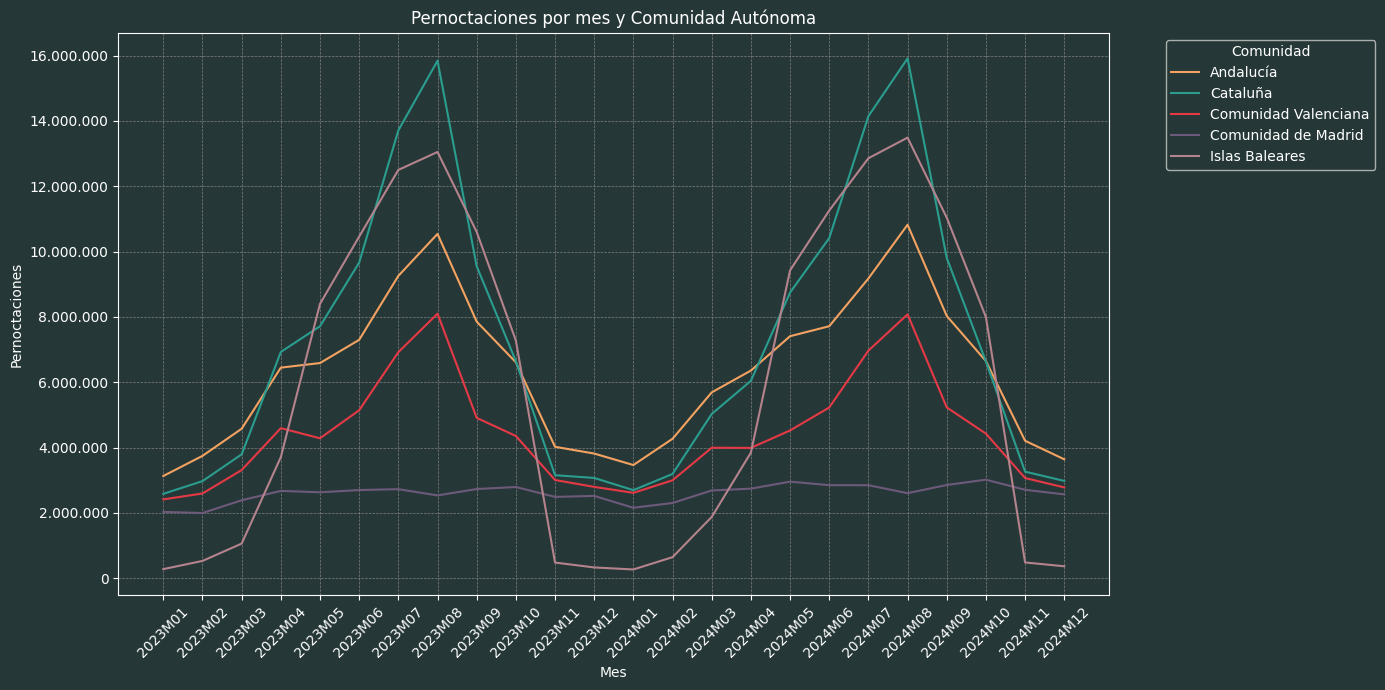

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Agrupar por comunidad y mes
ocupacion_por_ciudad = df_agrupado.groupby(
    ["periodo", "comunidad"]
)["pernoctaciones"].sum().reset_index()

# Reordenar comunidades para darles colores manualmente más contrastantes
comunidades = ocupacion_por_ciudad["comunidad"].unique()

paleta_reordenada = [
    "#F4A261", "#2A9D8F", "#E63946", "#6D597A", "#B5838D",
    "#3A5A40", "#1B3C59", "#A67C52", "#F4E285", "#264653"
]

with plt.style.context(estilo_corporativo):
    plt.figure(figsize=(14, 7))

    for i, comunidad in enumerate(comunidades):
        datos = ocupacion_por_ciudad[ocupacion_por_ciudad["comunidad"] == comunidad]
        color = paleta_reordenada[i % len(paleta_reordenada)]
        plt.plot(datos["periodo"], datos["pernoctaciones"], label=comunidad, color=color)

    plt.title("Pernoctaciones por mes y Comunidad Autónoma")
    plt.xlabel("Mes")
    plt.ylabel("Pernoctaciones")

    # Formato de miles con punto
    formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.'))
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.xticks(rotation=45)

    # Leyenda en blanco
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Comunidad")
    for text in legend.get_texts():
        text.set_color("white")
    legend.get_title().set_color("white")

    plt.tight_layout()
    plt.grid(True)
    plt.show()


#### Pernoctaciones por mes y residencia

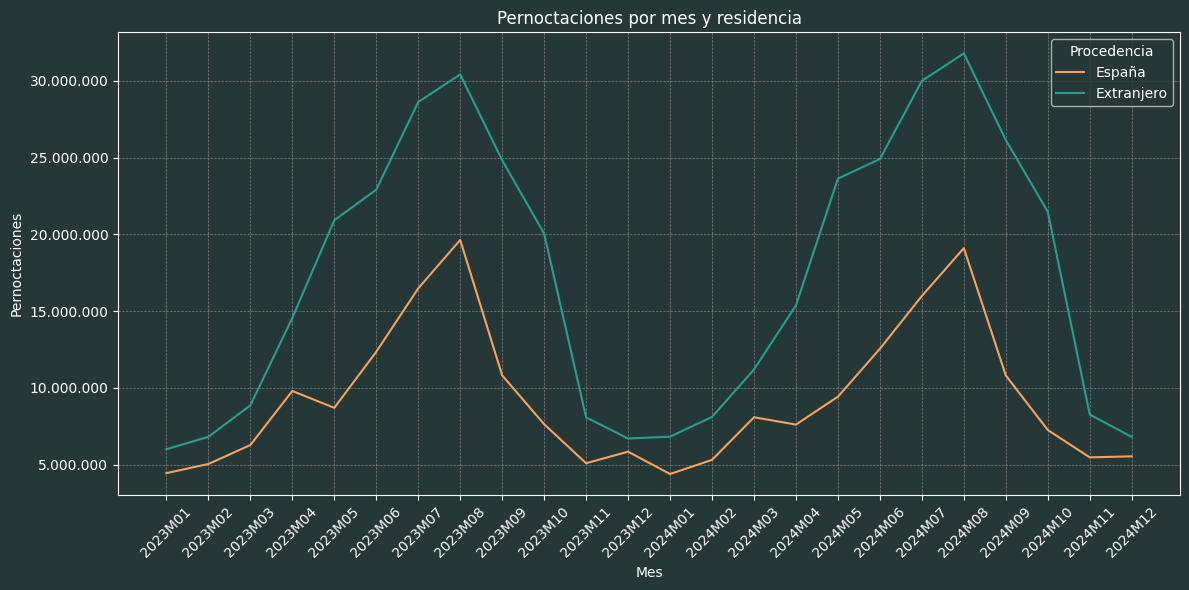

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Agrupar por mes y tipo de residencia
ocupacion_por_residencia = df_agrupado.groupby(
    ["periodo", "procedencia"]
)["pernoctaciones"].sum().reset_index()

with plt.style.context(estilo_corporativo):
    plt.figure(figsize=(12, 6))

    procedencias = ocupacion_por_residencia["procedencia"].unique()

    # Elegimos 2 colores contrastantes de la paleta para que se vean bien
    colores_contraste = {
        "España": "#F4A261",      # Naranja suave
        "Extranjero": "#2A9D8F"   # Verde esmeralda
    }

    for residencia in procedencias:
        datos = ocupacion_por_residencia[ocupacion_por_residencia["procedencia"] == residencia]
        plt.plot(datos["periodo"], datos["pernoctaciones"], label=residencia, color=colores_contraste[residencia])

    plt.title("Pernoctaciones por mes y residencia")
    plt.xlabel("Mes")
    plt.ylabel("Pernoctaciones")

    formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.'))
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.xticks(rotation=45)

    # Leyenda en blanco
    legend = plt.legend(title="Procedencia")
    for text in legend.get_texts():
        text.set_color("white")
    legend.get_title().set_color("white")

    plt.tight_layout()
    plt.grid(True)
    plt.show()




#### Pernoctaciones por mes, residencia y ciudad

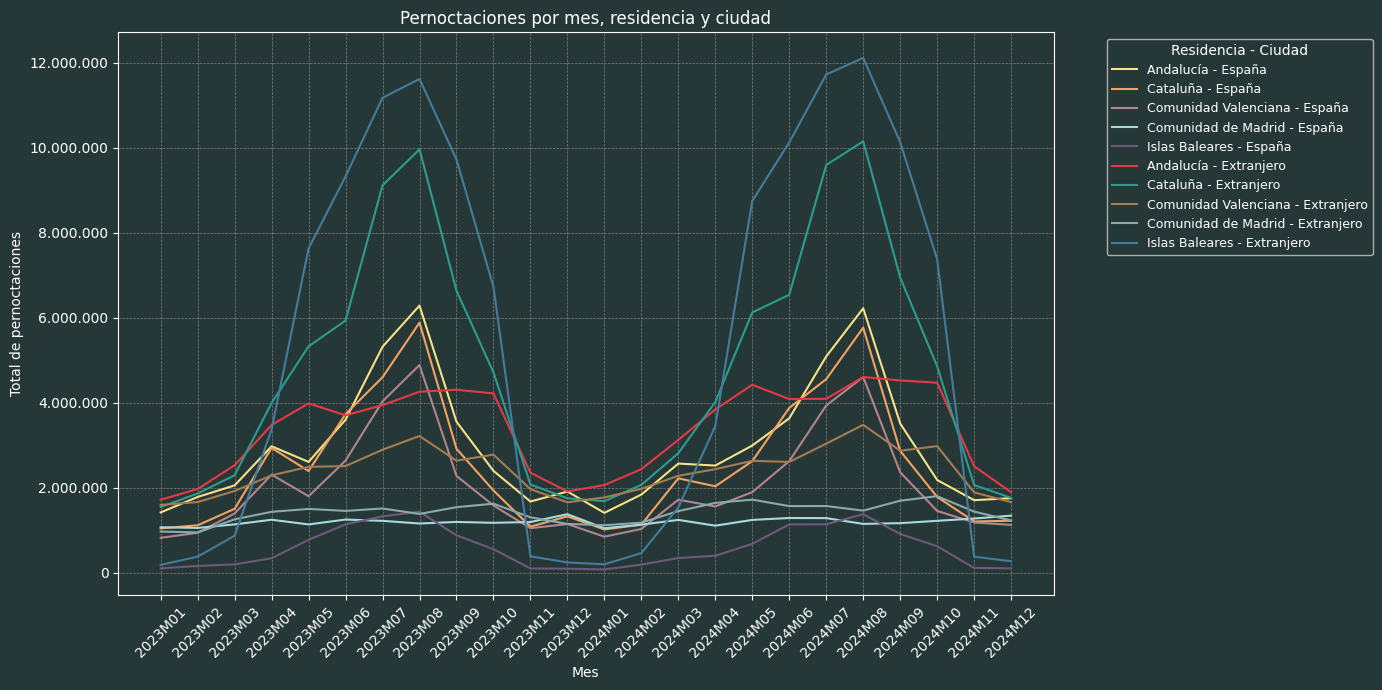

In [30]:
# Agrupar por mes, tipo de residencia y comunidad autónoma
ocupacion_por_residencia_y_ciudad = df_agrupado.groupby(
    ["periodo", "procedencia", "comunidad"]
)["pernoctaciones"].sum().reset_index()

# Colores personalizados para cada combinación
colores_custom = {
    "Andalucía - España": "#F4E285",
    "Cataluña - España": "#F4A261",
    "Comunidad Valenciana - España": "#B5838D",
    "Comunidad de Madrid - España": "#A8DADC",
    "Islas Baleares - España": "#6D597A",
    "Andalucía - Extranjero": "#E63946",
    "Cataluña - Extranjero": "#2A9D8F",
    "Comunidad Valenciana - Extranjero": "#A67C52",
    "Comunidad de Madrid - Extranjero": "#8BAAAD",  # ¡Nuevo color más visible!
    "Islas Baleares - Extranjero": "#457B9D"
}

with plt.style.context(estilo_corporativo):
    plt.figure(figsize=(14, 7))

    combinaciones = ocupacion_por_residencia_y_ciudad[["comunidad", "procedencia"]].drop_duplicates()

    for comunidad, procedencia in combinaciones.values:
        datos = ocupacion_por_residencia_y_ciudad[
            (ocupacion_por_residencia_y_ciudad["comunidad"] == comunidad) &
            (ocupacion_por_residencia_y_ciudad["procedencia"] == procedencia)
        ]
        etiqueta = f"{comunidad} - {procedencia}"
        color = colores_custom.get(etiqueta, "#D9D9D9")
        plt.plot(datos["periodo"], datos["pernoctaciones"], label=etiqueta, color=color)

    plt.title("Pernoctaciones por mes, residencia y ciudad")
    plt.xlabel("Mes")
    plt.ylabel("Total de pernoctaciones")

    formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.'))
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.xticks(rotation=45)
    legend = plt.legend(title="Residencia - Ciudad", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    for text in legend.get_texts():
        text.set_color("white")
    legend.get_title().set_color("white")

    plt.tight_layout()
    plt.grid(True)
    plt.show()


#### Pernoctación por comunidad y procedencia

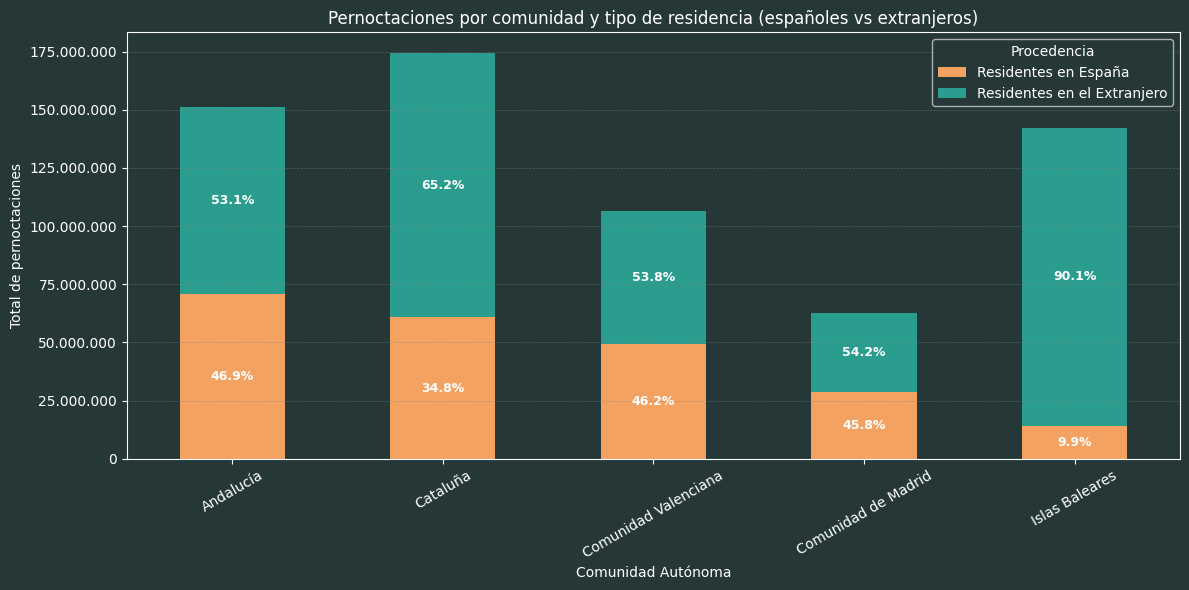

In [31]:
# Agrupar por comunidad autónoma y tipo de residencia
perfil_viajero = df_agrupado.groupby(["comunidad", "procedencia"])["pernoctaciones"].sum().unstack().fillna(0)

# Colores más contrastantes de tu paleta
colores = {
    "España": "#F4A261",      # Naranja suave
    "Extranjero": "#2A9D8F"   # Verde esmeralda
}

with plt.style.context(estilo_corporativo):
    ax = perfil_viajero.plot(
        kind="bar", 
        stacked=True, 
        figsize=(12, 6), 
        color=[colores["España"], colores["Extranjero"]]
    )

    plt.title("Pernoctaciones por comunidad y tipo de residencia (españoles vs extranjeros)")
    plt.xlabel("Comunidad Autónoma")
    plt.ylabel("Total de pernoctaciones")

    # Formatear Y en miles con punto
    formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.'))
    ax.yaxis.set_major_formatter(formatter)

    plt.xticks(rotation=30)
    legend = plt.legend(title="Procedencia", labels=["Residentes en España", "Residentes en el Extranjero"])
    for text in legend.get_texts():
        text.set_color("white")
    legend.get_title().set_color("white")

    # Añadir porcentajes dentro de las barras
    for idx, comunidad in enumerate(perfil_viajero.index):
        total = perfil_viajero.loc[comunidad].sum()
        bottom = 0
        for procedencia in perfil_viajero.columns:
            valor = perfil_viajero.loc[comunidad, procedencia]
            porcentaje = (valor / total) * 100 if total > 0 else 0
            ax.text(
                idx, 
                bottom + valor / 2, 
                f"{porcentaje:.1f}%", 
                ha='center', 
                va='center', 
                color='white', 
                fontsize=9, 
                fontweight='bold'
            )
            bottom += valor

    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()



#### Variación anual de las pernoctaciones por CA y procedencia

In [32]:
df_pernoc_ca_year_proced = df_agrupado.groupby(["comunidad", "year", "procedencia"])["pernoctaciones"].sum().reset_index()

df_pernoc_ca_year_proced = df_pernoc_ca_year_proced.pivot(index=["comunidad", "procedencia"], columns="year", values="pernoctaciones").fillna(0)

df_pernoc_ca_year_proced["variacion_porcentual"] = (df_pernoc_ca_year_proced.pct_change(axis=1).iloc[:, -1] * 100).round(1)

df_pernoc_ca_year_proced = df_pernoc_ca_year_proced.reset_index()
df_pernoc_ca_year_proced

year,comunidad,procedencia,2023,2024,variacion_porcentual
0,Andalucía,España,35555169,35403777,-0.4
1,Andalucía,Extranjero,38347283,42040355,9.6
2,Cataluña,España,30446163,30281801,-0.5
3,Cataluña,Extranjero,55189689,58591731,6.2
4,Comunidad Valenciana,España,24851467,24318516,-2.1
5,Comunidad Valenciana,Extranjero,27598231,29596567,7.2
6,Comunidad de Madrid,España,14188703,14472800,2.0
7,Comunidad de Madrid,Extranjero,16049306,17843962,11.2
8,Islas Baleares,España,7077769,7070789,-0.1
9,Islas Baleares,Extranjero,61610912,66487970,7.9


#### Estancia media por comunidad autónoma

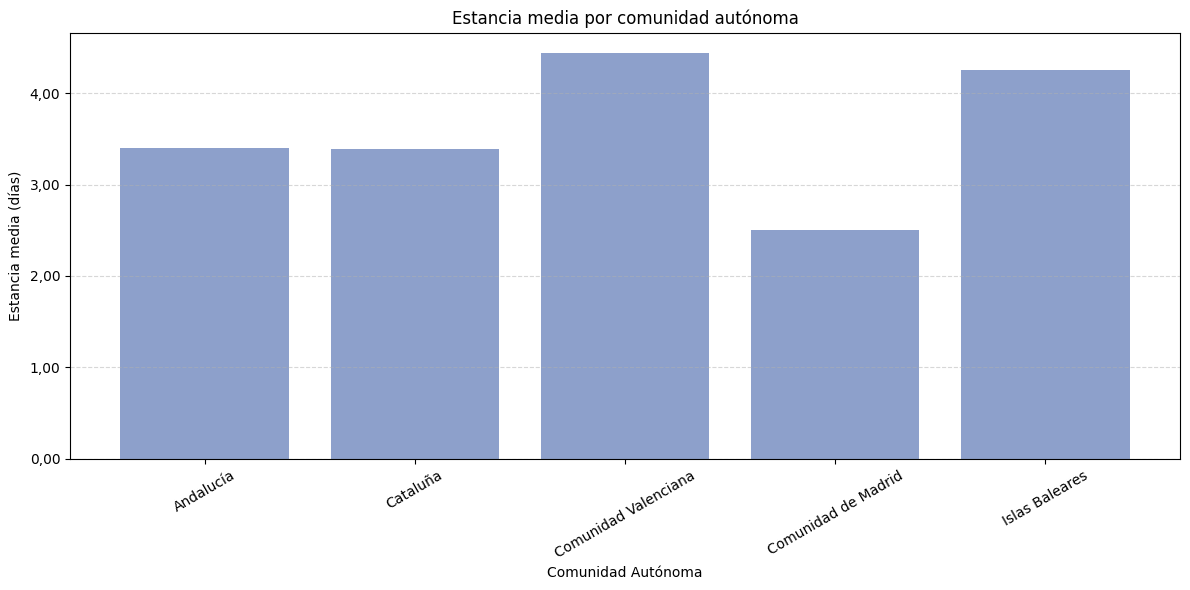

In [33]:
# Agrupar por comunidad y calcular la estancia media
estancia_media_comunidad = df_estancia.groupby("comunidad")["estancia_media"].mean().reset_index()

# Crear gráfico de barras con color más suave
plt.figure(figsize=(12, 6))
plt.bar(estancia_media_comunidad["comunidad"], estancia_media_comunidad["estancia_media"], color="#8da0cb")  # azul suave

plt.title("Estancia media por comunidad autónoma")
plt.xlabel("Comunidad Autónoma")
plt.ylabel("Estancia media (días)")

# Formatear eje Y con separadores de miles (por si algún valor fuera mayor de 1.000)
formatter = ticker.FuncFormatter(lambda x, _: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(rotation=30)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


In [37]:
estancia_media_comunidad

,comunidad,estancia_media
0,Andalucía,3.397500
1,Cataluña,3.384333
2,Comunidad Valenciana,4.437250
3,Comunidad de Madrid,2.505750
4,Islas Baleares,4.257582


#### Pernoctaciones por mes

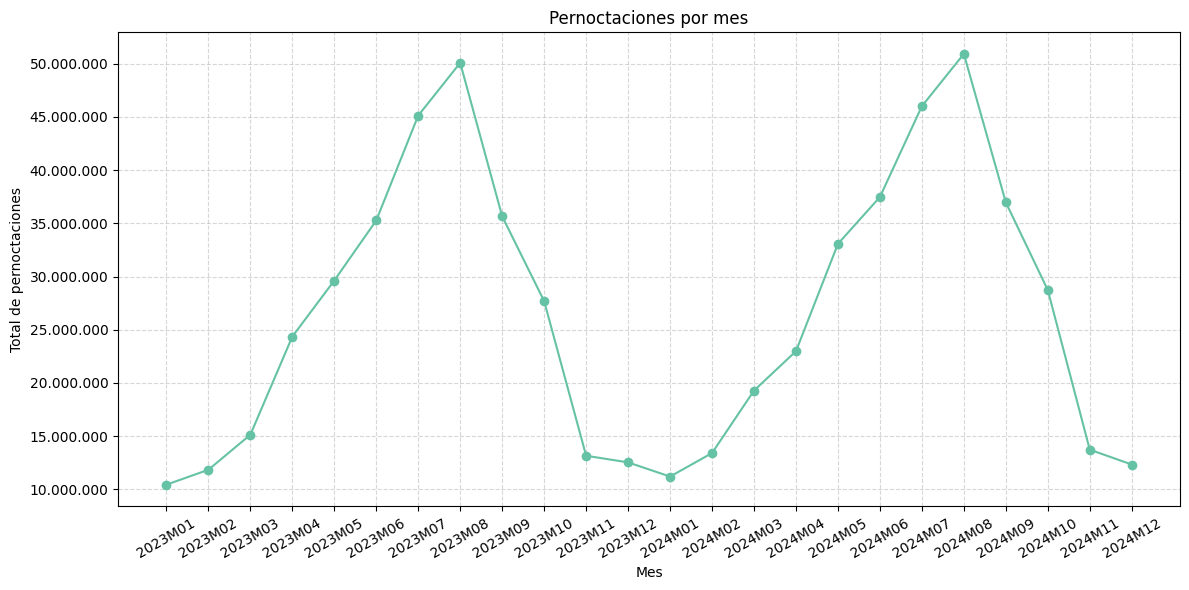

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Agrupar por mes para ver la ocupación total por mes
ocupacion_mes = df_agrupado.groupby("periodo")["pernoctaciones"].sum().reset_index()

# Crear gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(ocupacion_mes["periodo"], ocupacion_mes["pernoctaciones"], marker="o", color="#66c2a5")  # verde agua suave

plt.title("Pernoctaciones por mes")
plt.xlabel("Mes")
plt.ylabel("Total de pernoctaciones")

# Formatear el eje Y con puntos como separadores de miles
formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.'))
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(rotation=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [35]:
perfil_viajero

procedencia,España,Extranjero
comunidad,,
Andalucía,70958946,80387638
Cataluña,60727964,113781420
Comunidad Valenciana,49169983,57194798
Comunidad de Madrid,28661503,33893268
Islas Baleares,14148558,128098882


# Test ANOVA

In [36]:
# ANOVA unidireccional
modelo = ols("pernoctaciones ~ comunidad", data=df_agrupado).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print("Resultados ANOVA:")
print(anova_table)

# Prueba post-hoc de Tukey para ver diferencias entre pares de comunidades
tukey = pairwise_tukeyhsd(df_agrupado["pernoctaciones"], df_agrupado["comunidad"])
print("\nResultados de Tukey HSD:")
print(tukey)

Resultados ANOVA:
                 sum_sq     df         F    PR(>F)
comunidad  1.595951e+14    4.0  7.787216  0.000007
Residual   1.204052e+15  235.0       NaN       NaN

Resultados de Tukey HSD:
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
       group1               group2           meandiff   p-adj      lower         upper     reject
-------------------------------------------------------------------------------------------------
           Andalucía             Cataluña   482558.3333 0.8344   -787634.345  1752751.0117  False
           Andalucía Comunidad Valenciana  -937120.8958 0.2558 -2207313.5742   333071.7825  False
           Andalucía  Comunidad de Madrid -1849829.4375 0.0008 -3120022.1159  -579636.7591   True
           Andalucía       Islas Baleares     -189565.5  0.994 -1459758.1784  1080627.1784  False
            Cataluña Comunidad Valenciana -1419679.2292 0.0199 -2689871.9075  -149486.5508   True
            Cataluñ

Madrid presenta un número significativamente menor de pernoctaciones en comparación con Cataluña, Baleares y Andalucía, pero no muestra diferencias estadísticamente significativas con la Comunidad Valenciana. Estos resultados son consistentes con los datos agregados, donde ambas comunidades (Madrid y Valencia) registran las cifras más bajas de turismo en términos absolutos. En el caso Catalunya-Com.Valenciana tambien existe diferencia significativa.

# Tendencia

-Perfil del viajero: Residentes vs. Extranjeros<br>
Distribución por residencia: Según los gráficos de ocupación por tipo de residencia, las comunidades autónomas más turísticas (como Andalucía, Baleares, y Cataluña) presentan una alta ocupación de residentes extranjeros. Esto sugiere que hay una demanda constante de turistas internacionales, sobre todo en los meses de verano o vacaciones.<br>
Tendencia para el mercado nacional: El perfil de los viajeros residentes en España mantiene una ocupación más estable, aunque con fluctuaciones dependiendo de la estacionalidad. Las comunidades con mayor atracción para turistas internacionales también parecen ver una mayor ocupación de residentes españoles en los meses fuera de temporada alta (por ejemplo, en meses de baja demanda o invierno).<br>

-Demanda de pernoctaciones por mes<br>
Picos estacionales: La ocupación crece significativamente durante los meses de verano y festivos, lo que se traduce en una mayor demanda de pernoctaciones. Es evidente que el turismo se concentra en épocas de alta demanda.<br>

Las bajas temporadas muestran un descenso en las pernoctaciones, lo que indica que la demanda por pernoctaciones baja cuando no es temporada alta.<br>

-Estancia media por comunidad<br>
Diferencias en la estancia media: Algunas comunidades tienen una estancia media más larga, lo que sugiere que los turistas se quedan más tiempo en estas zonas. En cambio, las comunidades más urbanas o turísticas (por ejemplo, Madrid) pueden tener estancias más cortas. <br>

Las zonas rurales o costeras pueden tener estancias más largas, lo que implica que los viajeros en estas áreas buscan estancias más relajadas o vacaciones prolongadas.<br>

-Ajuste de ofertas por ciudad/comunidad<br>
Las comunidades autónomas más visitadas como Andalucía, Baleares y Cataluña siguen dominando la demanda de pernoctaciones, especialmente entre los turistas internacionales.<br>

Las zonas menos turísticas (rurales, como algunas comunidades del norte) muestran una ocupación más baja, lo que sugiere que estas áreas podrían necesitar incentivos adicionales para aumentar la ocupación.<br>

# Propuestas de Negocio

1. Ofertas especiales para turistas internacionales en temporada alta<br>
Propuesta: Durante los meses de alta demanda, especialmente en verano y vacaciones, aumentar la visibilidad de ofertas dirigidas a turistas internacionales. Esto puede incluir: <br>
-Paquetes turísticos o descuentos para grupos grandes (familias, amigos).<br>
-Ofertas de largo plazo para estancias prolongadas (de 1 semana o más).<br>
-Paquetes todo incluido o actividades complementarias como excursiones o entradas a eventos culturales en la comunidad.<br>
Objetivo: Maximizar la ocupación en los meses de alta demanda con promociones atractivas para el turismo internacional, que constituye una gran parte de la demanda en las comunidades más turísticas.

2. Promociones para residentes nacionales en temporada baja<br>
Propuesta: Reforzar las ofertas para residentes españoles durante los meses de baja ocupación.<br>
Esto puede incluir:<br>
-Descuentos especiales para residentes en comunidades con baja demanda (como zonas rurales o menos turísticas).<br>
-Promociones de fin de semana o escapadas de última hora en las ciudades menos visitadas.<br>
-Descuentos por estancias más largas (por ejemplo, estancias de 5 noches o más en zonas rurales o zonas con estancias largas).<br>
Objetivo: Atraer a los residentes españoles para mantener la ocupación durante los meses fuera de temporada alta y utilizar las temporadas bajas para equilibrar la demanda.

3. Ajustar la oferta según la estancia media<br>
Propuesta: Según la diferencia en la estancia media de cada comunidad, ajusta la oferta para que sea adecuada a la duración de la estancia:<br>
-En zonas con estancias largas (por ejemplo, Andalucía o Baleares), ofrecer descuentos por estancias prolongadas o paquetes de todo el mes.<br>
-En zonas con estancias más cortas, ofrecer paquetes rápidos o flexibles, como estancias de 1 a 3 noches, e incentivar la venta cruzada (por ejemplo, incluir actividades o servicios adicionales como transporte o excursiones).<br>
Objetivo: Adaptar la oferta a la duración de la estancia media para maximizar la ocupación, ofreciendo promociones específicas que encajen con el tipo de viajero en cada región.

4. Fomentar el turismo en zonas menos visitadas<br>
Propuesta: Para las comunidades autónomas con menos ocupación, crear campañas de marketing que resalten las ventajas de estas áreas menos turísticas. <br>
Algunas ideas incluyen:<br>
-Paquetes de fin de semana en zonas rurales o menos turísticas.<br>
-Promociones de última hora para atraer a turistas nacionales (residentes en España) que busquen destinos más tranquilos.<br>
-Establecer alianzas con empresas locales para crear paquetes de experiencias que promuevan el turismo rural (por ejemplo, senderismo, visitas a bodegas, actividades culturales).<br>
Objetivo: Reducir la dependencia de las zonas más turísticas y equilibrar la demanda en otras comunidades, atrayendo turistas nacionales durante los meses de baja ocupación.

5. Crear ofertas temáticas según el tipo de residencia<br>
Propuesta: Segmentar las ofertas según el tipo de residencia:<br>
-Para residentes españoles, crear promociones centradas en escapadas locales o turismo de cercanía.<br>
-Para turistas internacionales, diseñar ofertas relacionadas con experiencias culturales o actividades exclusivas que les permitan disfrutar de la cultura española.<br>
Ofertas combinadas para viajeros internacionales con estancias más largas que incluyan servicios adicionales (como traslados o actividades) que optimicen su experiencia.<br>
Objetivo: Personalizar la oferta para que se ajuste a las necesidades del tipo de viajero, mejorando la satisfacción y la conversión de ventas.

6. Diversificación de productos según la temporada<br>
Propuesta: Desarrollar productos adaptados a la temporada:<br>
-Durante la temporada baja, ofrecer productos de relajación y bienestar, como spas, retiros de bienestar o escapadas románticas.<br>
-En la temporada alta, centrarse en experiencias de aventura o actividades grupales como festivales, excursiones, y actividades culturales.<br>
-Promover las vacaciones activas en las zonas rurales durante la temporada baja, aprovechando la tranquilidad de la zona.<BR>
Objetivo: Asegurarse de que los productos sean relevantes para las preferencias del viajero según la temporada, mejorando la tasa de ocupación durante todo el año.<br>
Estas estrategias personalizan las ofertas según las tendencias actuales y las necesidades del mercado, lo que permitirá ajustar la oferta a la demanda y optimizar las tasas de ocupación.<br>
